In [1]:
#Libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import random
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

In [2]:
from src.FC_NN_Architecture import *
# Dataset Loader File
from src.DF_DataLoader import initDataset, toDataset

In [3]:
# Data visualization of NN
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange

In [4]:
import scipy.io
from matplotlib import cm
import matplotlib
from matplotlib.ticker import MaxNLocator

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Lambda network and its performance

In [5]:
font = {'family' : 'sans-serif', 'weight' : 'normal'} 
plt.rc('font', **font)

In [6]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [7]:
df = pd.read_feather(f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_5.0_TestingData.feather")

In [8]:
np.sqrt(np.mean((df['c1_t'].values - df['c1_est'].values)**2))

0.29491648361332345

## Lambda estimates: histogram

BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:40<00:00, 26.52batch/s]


BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:42<00:00, 25.22batch/s]


BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [00:43<00:00, 24.40batch/s]


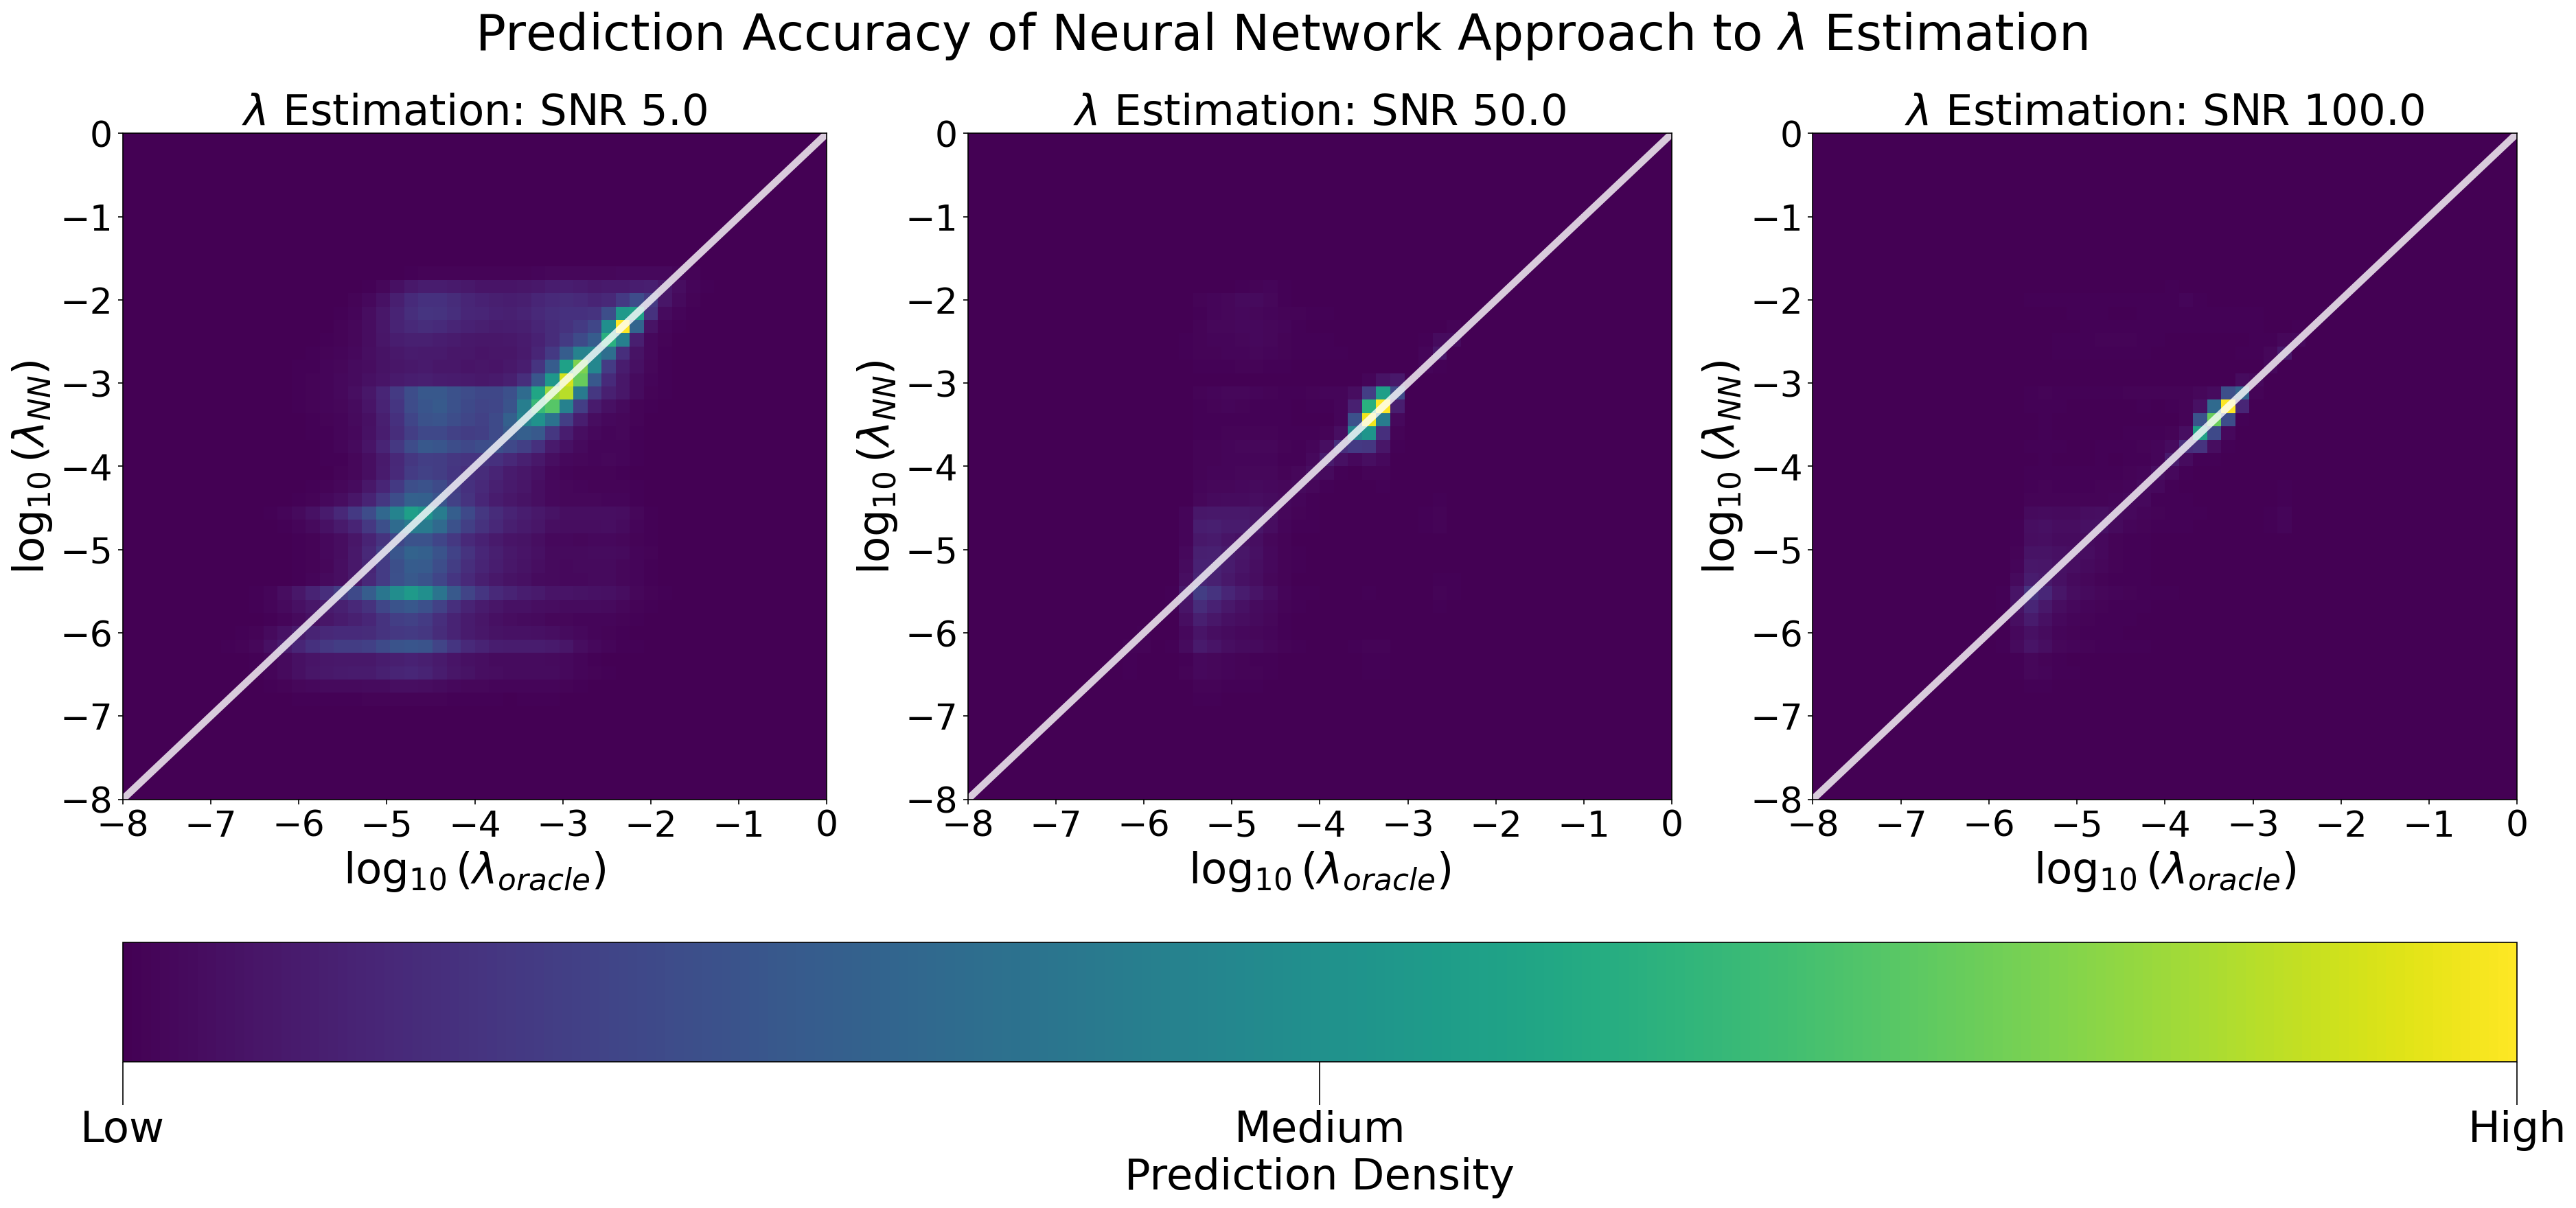

In [11]:
results_list = []
fig = plt.figure(figsize = (30,12), dpi = 150)
axes_3d = []
for i, snr in enumerate([5.0,50.0,100.0]):

    training_path = f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_TrainingData.feather"
    testing_path =  f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_TestingData.feather"
    
    convolutional = True
    training_dataset = initDataset(training_path, set_type = "training", type1 = "standardized", convolutional = convolutional)
    testing_dataset = initDataset(testing_path, set_type = "validation", type1 = "standardized", mean_targ= training_dataset.mean2, std_targ= training_dataset.stdev, convolutional = convolutional)
    
    device = torch.device("cuda:0") #WAS CUDA:7
    
    lambda_model_path =f"LambdaSelectionNetworks/Experimentation_DenseRician_LambdaNN_SNR_{snr}MPE_1_lr1e3_B512.pth"
    checkpoint = torch.load(lambda_model_path, map_location=device)
    
    compiled_model = LambdaTraining_FC_NN_Convolutional_SELU(in_channel=1, out1 = 128, out2 = 256, k1 = 5, k2 = 3, fc1 = 512, fc2 = 64, out_dim=1)
    compiled_model = compiled_model.to(device)
    compiled_model.load_state_dict(checkpoint['model_state_dict'])
    compiled_model.eval()

    testing_loader = DataLoader(testing_dataset, batch_size = 3000)
    with torch.no_grad():
        training_preds_t = torch.empty(len(testing_loader.dataset))
        curr_pos_reg = 0
        end_pos_reg = 0
        for idx, (noisy_decay, targets) in enumerate(tqdm(testing_loader, unit = "batch")):
            batch_size = noisy_decay.size(0)
            end_pos_reg += batch_size
            assert(torch.all(noisy_decay == (testing_loader.dataset.training_tensor_proc)[curr_pos_reg : end_pos_reg]))
            
            noisy_decay, targets = noisy_decay.to(device), targets.unsqueeze(1).to(device)
                
            predictions = compiled_model(noisy_decay.float())
            training_preds_t[curr_pos_reg : end_pos_reg] = (predictions.squeeze(1) * training_dataset.stdev) + training_dataset.mean2
            curr_pos_reg += batch_size
    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    lam_oracle = (testing_dataset.target_tensor_proc*training_dataset.stdev + training_dataset.mean2).detach().numpy()
    data = training_preds_t.detach().cpu().numpy()
    global_minpred = np.min(np.stack([data, lam_oracle]))
    global_maxpred = np.max(np.stack([data, lam_oracle]))
    ax = fig.add_subplot(1,3,i+1)
    h = ax.hist2d(data, lam_oracle, bins = 50, range=[[-8.0,0.0], [-8.0,0.0]])
    xx = np.linspace(-8.0,0.0,100)

    ax.plot(xx,xx, color = 'white', linewidth = 5.0, alpha = 0.8)
    ax.set_title(f"$\lambda$ Estimation: SNR {snr}", fontsize = 30)
    ax.set_xlabel("$\log_{10}(\lambda_{oracle})$", fontsize = 30)
    ax.set_ylabel("$\log_{10}(\lambda_{NN})$", fontsize = 30)

    ax.xaxis.set_tick_params(labelsize = 25)
    ax.yaxis.set_tick_params(labelsize = 25)
    
    ax.xaxis.set_major_locator(MaxNLocator(integer = True))
    ax.yaxis.set_major_locator(MaxNLocator(integer = True))
    axes_3d.append(ax)
    if i == 2:
        cbar = fig.colorbar(h[3], ax=axes_3d,location = 'bottom', ticks=[h[0].min(), h[0].max()//2, h[0].max()])
        cbar.set_label(label = "Prediction Density", size = 30)
        cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])
        cbar.ax.tick_params(size=30, labelsize = 30)
fig.suptitle("Prediction Accuracy of Neural Network Approach to $\lambda$ Estimation", fontsize = 35)
fig.savefig(f'LambdaEstimations_NN_squared.pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()

## Compare wrt GCV

BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2134/2134 [00:30<00:00, 70.12batch/s]


BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2134/2134 [00:31<00:00, 66.92batch/s]


BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2134/2134 [00:29<00:00, 71.56batch/s]


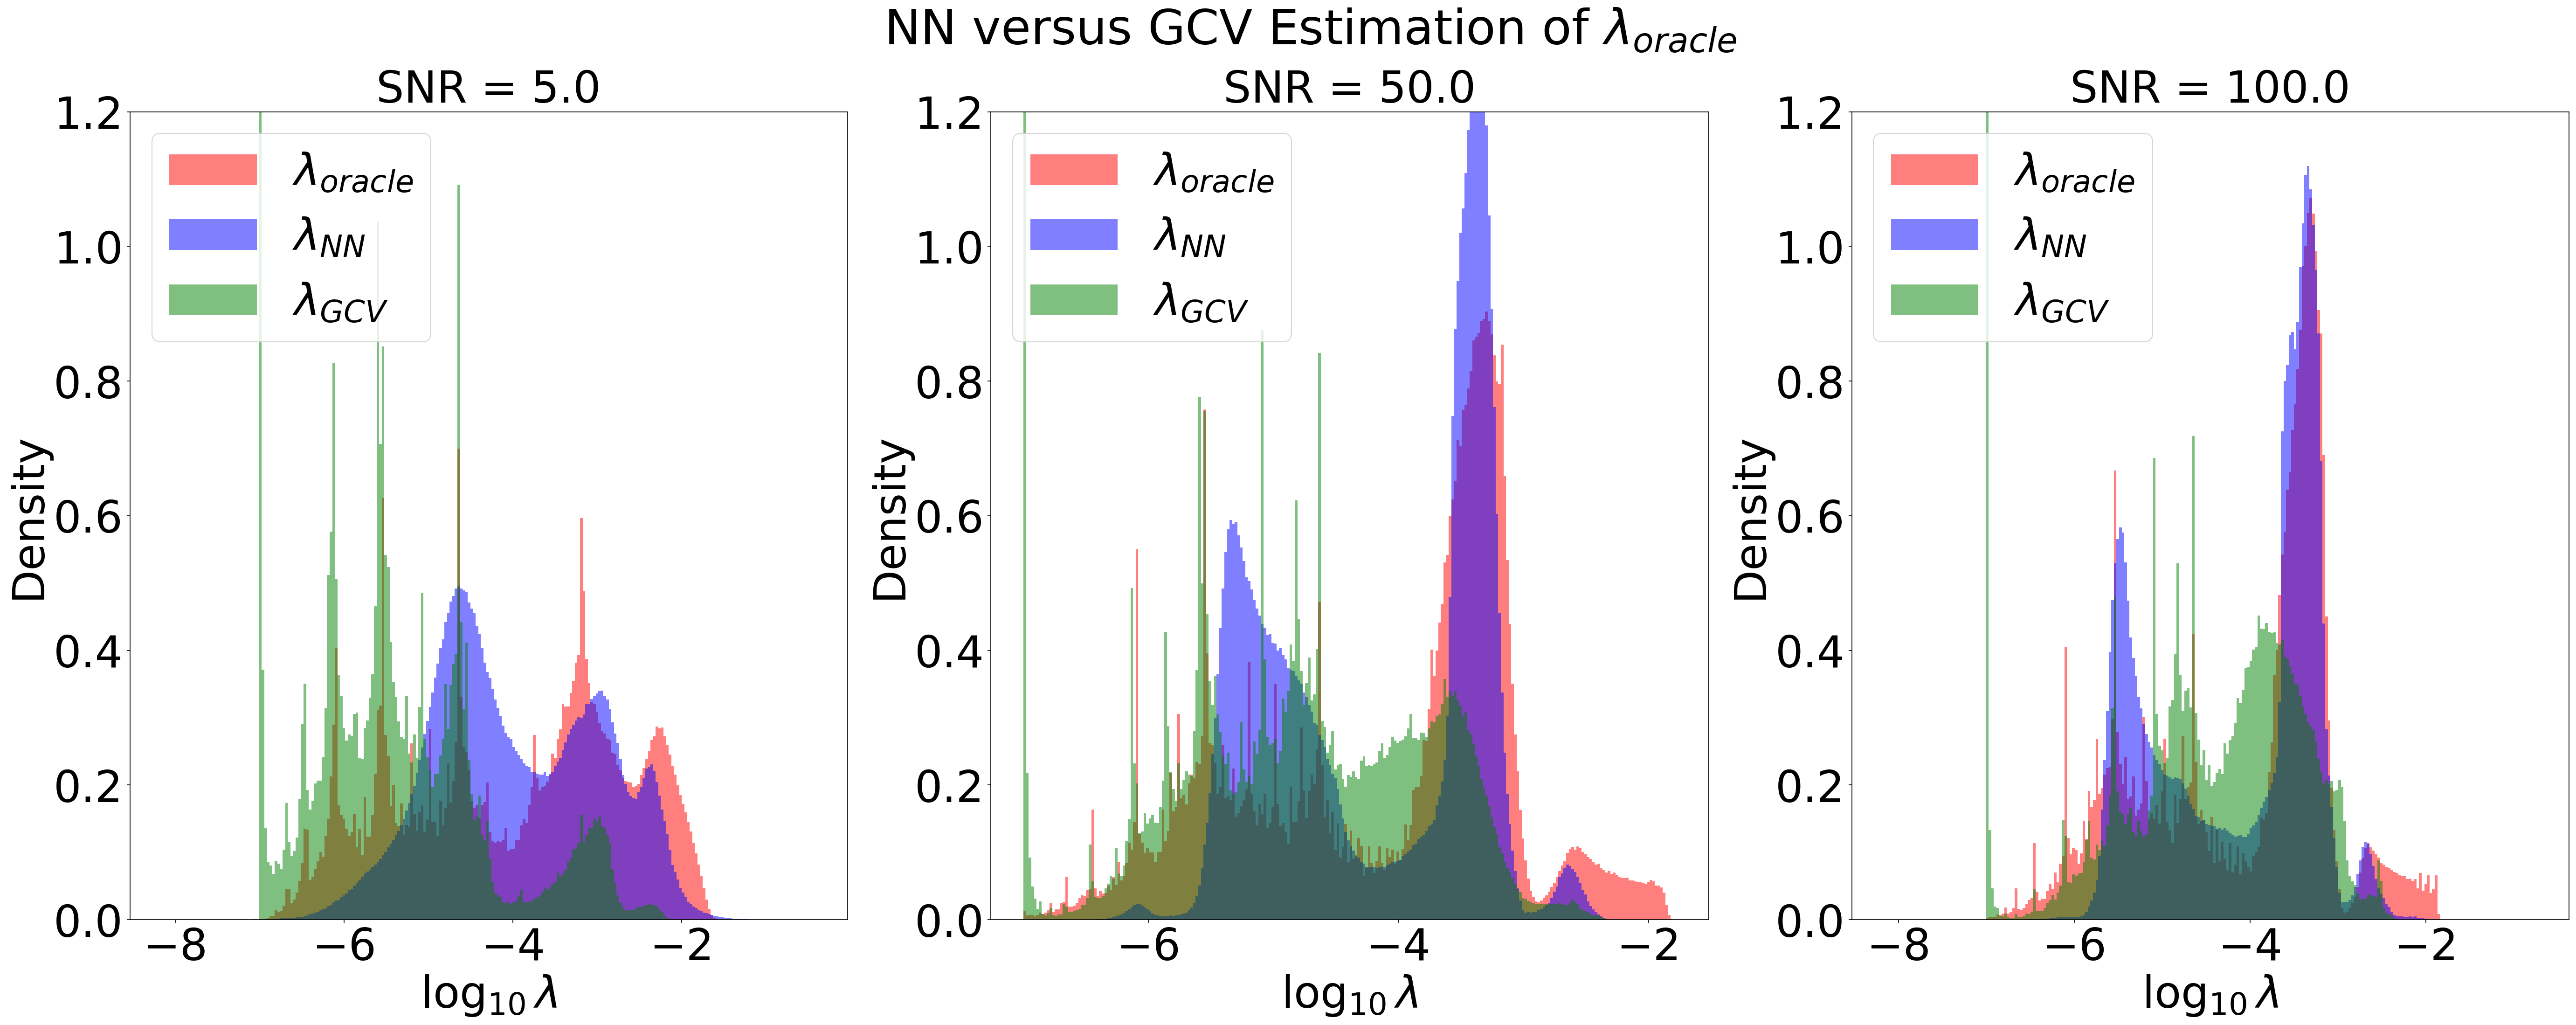

In [10]:
# results_list = []
fig = plt.figure(figsize=(45,15), dpi = 150)
for i, snr in enumerate([5.0,50.0,100.0]):
    training_path = f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_TrainingData.feather"
    testing_path =  f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{snr}_TestingData.feather"

    convolutional = True
    training_dataset = initDataset(training_path, set_type = "training", type1 = "standardized", convolutional = convolutional)
    testing_dataset = initDataset(testing_path, set_type = "validation", type1 = "standardized", mean_targ= training_dataset.mean2, std_targ= training_dataset.stdev, convolutional = convolutional)

    testing_GCV = f"LambdaGCVs/LambdaGCVs_Testing_SNR_{snr}_BrainRicianNoise.feather"
    df = pd.read_feather(testing_GCV)
    df["Index"] = df["Index"].astype(int)
    df.set_index("Index", inplace = True, drop = True)
    df.sort_index(inplace = True)
        
    gcv_lams = torch.from_numpy(np.stack(df["lambda_pred"].values))

    device = torch.device("cuda:0") #WAS CUDA:7

    lambda_model_path =f"LambdaSelectionNetworks/Experimentation_DenseRician_LambdaNN_SNR_{snr}MPE_1_lr1e3_B512.pth"
    checkpoint = torch.load(lambda_model_path, map_location=device)

    compiled_model = LambdaTraining_FC_NN_Convolutional_SELU(in_channel=1, out1 = 128, out2 = 256, k1 = 5, k2 = 3, fc1 = 512, fc2 = 64, out_dim=1)
    compiled_model = compiled_model.to(device)
    compiled_model.load_state_dict(checkpoint['model_state_dict'])
    compiled_model.eval()

    testing_loader = DataLoader(testing_dataset, batch_size = 1500, num_workers=32, pin_memory=True, persistent_workers=True)


    with torch.no_grad():
        training_preds_t = torch.empty(len(testing_loader.dataset))
    #     batch_size = len(dataload.dataset)//len(dataload)
#         scaling = torch.tensor([1.0,1.0,100.0], dtype = float, device = device)
        curr_pos_reg = 0
        end_pos_reg = 0
        for idx, (noisy_decay, targets) in enumerate(tqdm(testing_loader, unit = "batch")):
            batch_size = noisy_decay.size(0)
            end_pos_reg += batch_size
            assert(torch.all(noisy_decay == (testing_loader.dataset.training_tensor_proc)[curr_pos_reg : end_pos_reg]))
            
            noisy_decay, targets = noisy_decay.to(device), targets.unsqueeze(1).to(device)
                
            predictions = compiled_model(noisy_decay.float())
#             loss = (((predictions - targets)*scaling)**2).mean()
#             rL += loss.item() * batch_size
            training_preds_t[curr_pos_reg : end_pos_reg] = (predictions.squeeze(1) * training_dataset.stdev) + training_dataset.mean2
            curr_pos_reg += batch_size
    
    # preds = lambdas_t2s.detach().numpy()
    # g_truth2 = testing_dataset.target_tensor_proc.detach().numpy()
    preds = training_preds_t.detach().cpu().numpy()
    g_truth2 = (testing_dataset.target_tensor_proc*training_dataset.stdev + training_dataset.mean2).detach().numpy()
    
    
    ax = fig.add_subplot(1,3,i+1)
    bins = ax.hist(np.hstack((preds, g_truth2, gcv_lams)), bins = 250, alpha = 0.0, density=True)[1]
    ax.hist(g_truth2, bins, color = 'r', alpha=0.5, label = r'$\lambda_{oracle}$', density=True)
    ax.hist(preds, bins, color = 'b', alpha=0.5, label = r'$\lambda_{NN}$', density=True)
    ax.hist(gcv_lams, bins, color = 'green', alpha=0.5, label = r'$\lambda_{GCV}$', density=True)
    ax.set_xlabel("$\log_{10}{\lambda}$", fontsize = 45)
    ax.set_ylabel("Density", fontsize = 45)
    ax.tick_params(axis='both', which='major', labelsize=45)
    ax.set_title("SNR = " + str(snr), fontsize = 45)
    # plt.axvline(0.0, color = 'g', label = "0.0")
    ax.set_ylim((0,1.2))
    ax.legend(fontsize=45, loc = 'upper left')

fig.suptitle("NN versus GCV Estimation of $\lambda_{oracle}$", fontsize=50)
# fig.savefig(f'GCV_Comparisons_1D_histogram.pdf', dpi=fig.dpi, bbox_inches='tight')
fig.show()